In [ ]:
import numpy as np
import torch
import lightning.pytorch as pl
from albumentations.pytorch import ToTensorV2
from glob import glob
import albumentations as A
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import LearningRateMonitor
import sys

sys.path.append("..")
from src.utils import calculate_score
from src.dataset import BoneDataModule, BoneDataset
from src.model import BoneNet

In [ ]:
SEED = 123
IMAGE_DIR = "./2_5D_images"

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [3]:
img_paths = glob(f"{IMAGE_DIR}/*.png")

In [ ]:
train_transforms = A.Compose(
    [
        A.RGBShift(),
        # A.UnsharpMask(),
        A.RandomBrightnessContrast(),
        A.HorizontalFlip(),
        A.Normalize(),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose([A.Normalize(), ToTensorV2()])

In [ ]:
dm = BoneDataModule(
    IMAGE_DIR, train_transforms=train_transforms, val_transforms=val_transforms
)

In [ ]:
# Train set fold 0
image_shapes = []
plate_idx_train = []

dm.setup(stage="train")
for images, plates in dm.train_dataloader():
    image_shapes.append(images.shape)
    plate_idx_train.extend(list(plates.numpy()))

print(set(image_shapes))
print(np.mean(plate_idx_train))
# Val set fold 0

image_shapes = []
plate_idx_val = []

dm.setup(stage="validation")
for images, plates in dm.val_dataloader():
    image_shapes.append(images.shape)
    plate_idx_val.extend(list(plates.numpy()))

print(set(image_shapes))
print(np.mean(plate_idx_val))

{torch.Size([20, 3, 512, 512]), torch.Size([32, 3, 512, 512])}
0.34997118
{torch.Size([18, 3, 512, 512])}
0.3408203


In [12]:
train_mean = np.round(np.mean(plate_idx_train) * 512)
train_mean

179.0

In [13]:
# Score if the model predicted the mean of the growth plate indeces
np.mean(calculate_score(train_mean, np.array(plate_idx_val) * 512))

0.13797078558692205

In [ ]:
test_dst = BoneDataset(
    ["2_5D_images8bit/b599f11ab8_slice_x0_y0_gp_215.png"], transforms=val_transforms
)

In [48]:
test_dst[0][0][0].mean()

tensor(-1.7832)

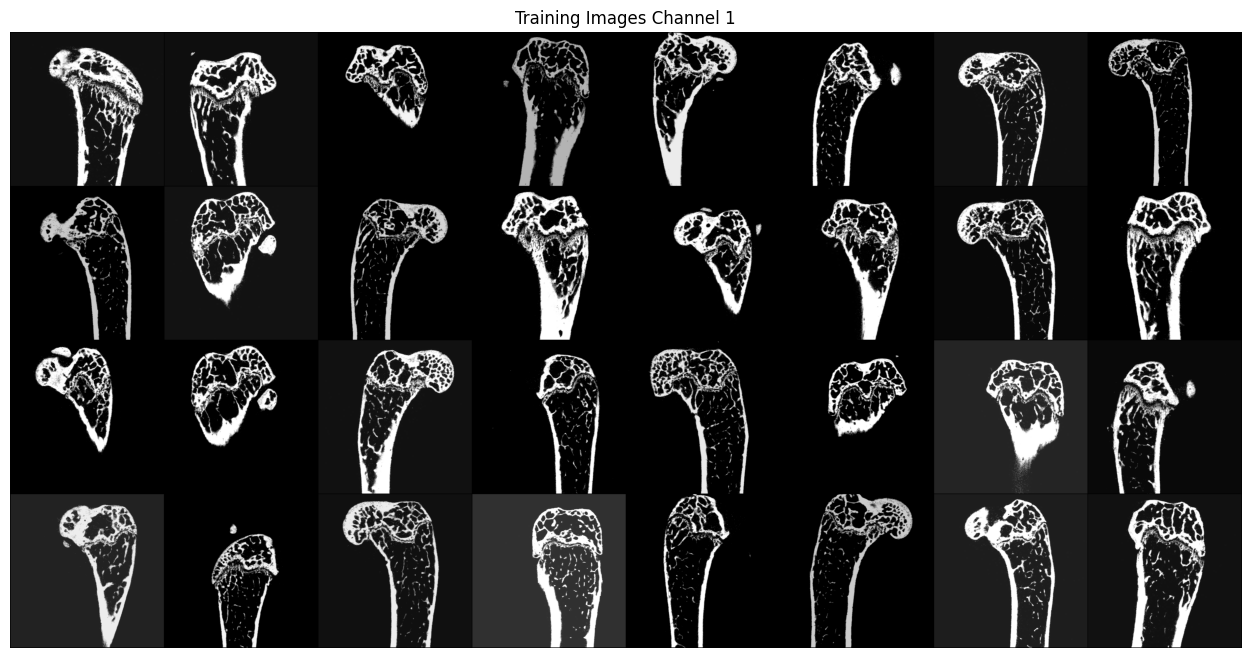

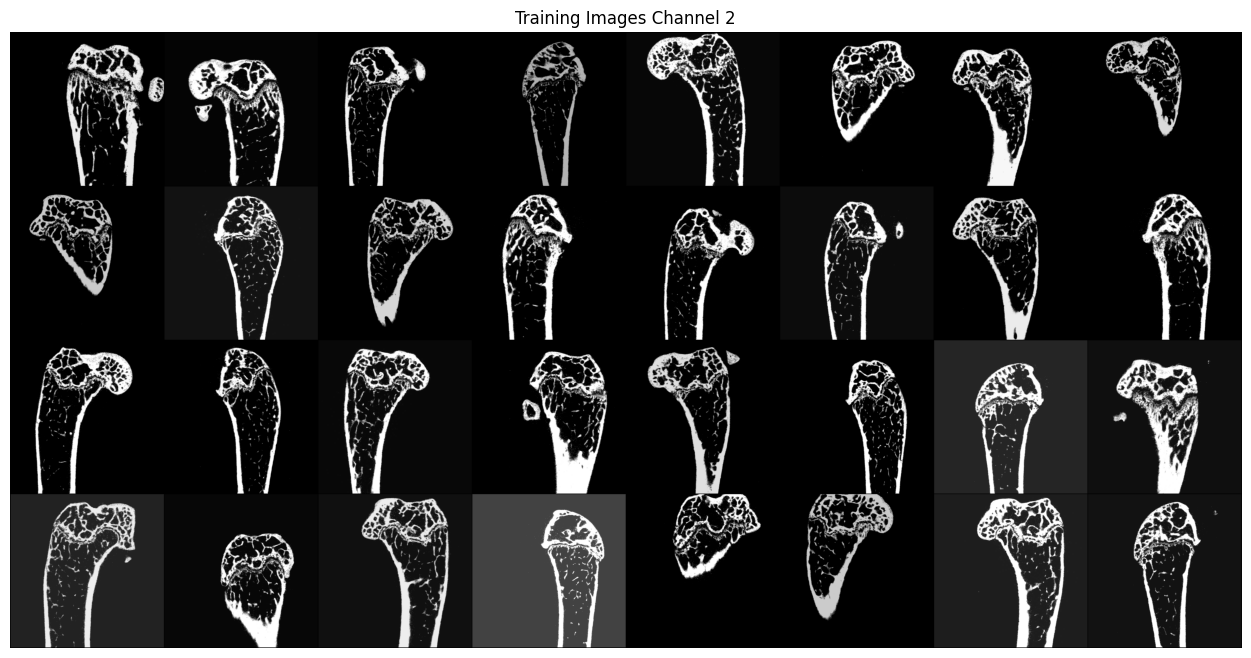

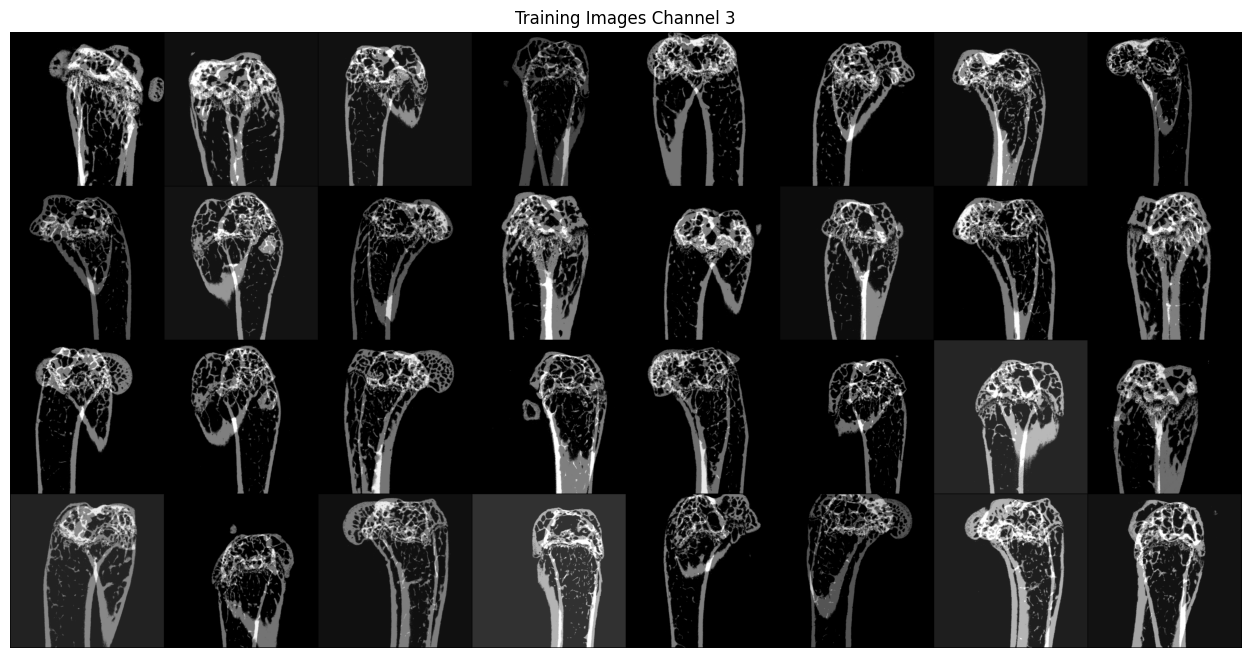

In [14]:
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

for images, labels in dm.train_dataloader():
    break

for c in range(3):
    
    plt.figure(figsize=(16,8))
    plt.axis("off")
    plt.title(f"Training Images Channel {c+1}")
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        images[:, c, : :].unsqueeze(1),
        padding=2,
        normalize=True),
        (1,2,0)))
    plt.show()


In [ ]:
# Learning rate finder
from lightning.pytorch.tuner import Tuner

dm = BoneDataModule(
    IMAGE_DIR,
    batch_size=32,
    train_transforms=train_transforms,
    val_transforms=val_transforms,
)
model = BoneNet(model_name="efficientnet_es_pruned")
# trainer = pl.Trainer(max_epochs=10, accelerator="auto", devices="auto")
# tuner = Tuner(trainer)

# lr_finder = tuner.lr_find(model, dm)

# Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

In [ ]:
# Cross validation
NUM_FOLDS = 4

scores = []
for i in range(NUM_FOLDS):
    dm = BoneDataModule(
        IMAGE_DIR,
        batch_size=32,
        train_transforms=train_transforms,
        val_transforms=val_transforms,
        splits=NUM_FOLDS,
        fold=i,
    )
    model = BoneNet(model_name="efficientnet_es_pruned", lr=1e-3, wd=1e-2)

    logger = CSVLogger("logs", name=f"bonenet_fold{i}")
    lr_monitor = LearningRateMonitor(logging_interval="step")

    trainer = pl.Trainer(
        max_epochs=12,
        accelerator="auto",
        devices="auto",
        logger=logger,
        callbacks=[lr_monitor],
    )
    trainer.fit(model, dm)

    trainer.save_checkpoint(f"effnet_fold{i}.ckpt")

    scores.append(model.final_score)

print(np.mean(scores))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name         | Type                  | Params
-------------------------------------------------------
0 | model        | EfficientNet          | 4.2 M 
1 | loss_fn      | MSELoss               | 0     
2 | val_sf_score | SurvivalFunctionScore | 0     
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.635    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name         | Type                  | Params
-------------------------------------------------------
0 | model        | EfficientNet          | 4.2 M 
1 | loss_fn      | MSELoss               | 0     
2 | val_sf_score | SurvivalFunctionScore | 0     
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.635    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name         | Type                  | Params
-------------------------------------------------------
0 | model        | EfficientNet          | 4.2 M 
1 | loss_fn      | MSELoss               | 0     
2 | val_sf_score | SurvivalFunctionScore | 0     
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.635    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/bonenet_fold3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name         | Type                  | Params
-------------------------------------------------------
0 | model        | EfficientNet          | 4.2 M 
1 | loss_fn      | MSELoss               | 0     
2 | val_sf_score | SurvivalFunctionScore | 0     
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.635    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


0.8038784265518188


In [94]:
print(np.mean(scores))

0.8038784265518188
